## Load useful libraries

In [1]:
import pickle
import json

from tensorflow.keras.models import model_from_json

from plotting_utilities import plot_basic_loss

2025-01-15 12:29:09.967972: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 12:29:09.999471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 12:29:09.999495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 12:29:10.000344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 12:29:10.005549: I tensorflow/core/platform/cpu_feature_guar

## Specify which training run we are investigating

In [2]:
application_root_directory = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning'
model_training_output_directory = application_root_directory + '/output/'

In [3]:
#training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----afc4d8d7-e500-4a07-9063-4e46cdecea7e'
#training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----3946abec-9ef2-43b8-a0dd-930e0a93471e'

# 200 epochs, constant learning rate
training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----eb540bb2-a954-49c0-addc-bcbf85cda01b'

In [4]:
history_file = model_training_output_directory + '/' + training_run + '_final_history_regressor.pickled'

## Load the training history

In [5]:
with open(history_file, 'rb') as f:
    history = pickle.load(f)

## Plot loss

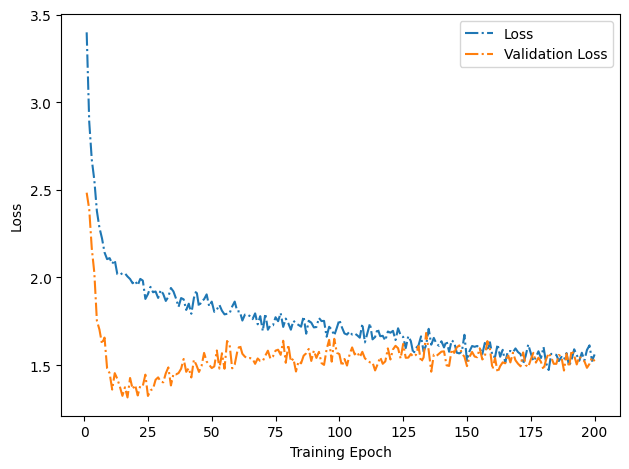

In [6]:
plot_basic_loss(history)

In [8]:
model_json_filename = model_training_output_directory + '/' + training_run + '_model_regressor.json'
model_final_weights_filename = model_training_output_directory + '/' + training_run + '_final_weights_regressor.pickled'

# Load the JSON file containing the model architecture
with open(model_json_filename, 'r') as json_file:
    loaded_model_json = json_file.read()

# Create a new model from the JSON
model = model_from_json(loaded_model_json)

# Load the weights into the new model
model.load_weights(model_final_weights_filename)

2025-01-15 12:30:40.497126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 605 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:65:00.0, compute capability: 7.5


In [9]:
model

In [10]:
filename_train_val_test_data = (
    model_training_output_directory 
    + training_run.split('----')[0]
    + '_train_val_test_dict.pickled'
)

with open(filename_train_val_test_data, 'rb') as f:
    train_val_test_dict = pickle.load(f)

In [11]:
M_test = train_val_test_dict['test']['M']
y_test = train_val_test_dict['test']['y']
n_test = train_val_test_dict['test']['n']
position_test = train_val_test_dict['test']['position']

In [12]:
M_test.shape

(1270, 120, 5)

In [14]:
y_predicted = model.predict(M_test)
y_predicted.shape

40/40 [==============================] - 5s 127ms/step


(1270, 2)

In [19]:
import matplotlib.pyplot as plt

def plot_a_prediction(
    M,
    y,
    y_predicted,
    index = 5,
    n_y_forward = 15, # get this from somewhere else
    color_known_y = 'purple',
    color_predicted_y = 'magenta',
):

    X_all_scaled_index = 0  # this is the index for the main time series we are predicted

    x = M_test[index, :, X_all_scaled_index]
    y_known_min = y_test[index, 0]
    y_known_max = y_test[index, 1]
    y_predicted_min = y_predicted[index, 0]
    y_predicted_max = y_predicted[index, 1]

    n_full = len(x) + n_y_forward + 1
    xmin = 120. / n_full
    xmax = (120 + n_y_forward) / n_full

    plt.figure()
    plt.plot(x, label = 'Known Past')

    plt.axhline(y = y_known_min, xmin = xmin, xmax=xmax, color = color_known_y, label = 'Known Future')
    plt.axhline(y = y_known_max, xmin = xmin, xmax=xmax, color = color_known_y)

    plt.axhline(y = y_predicted_min, xmin = xmin, xmax=xmax, color = color_predicted_y, label = 'Predicted Future')
    plt.axhline(y = y_predicted_max, xmin = xmin, xmax=xmax, color = color_predicted_y)

    plt.xlim(0, n_full)
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

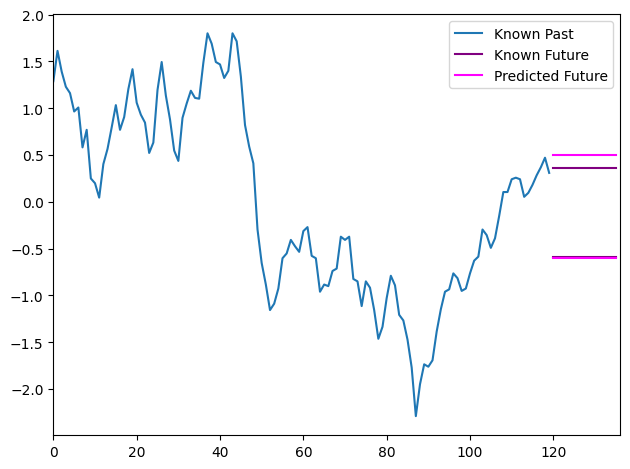

In [20]:
plot_a_prediction(M_test, y_test, y_predicted)

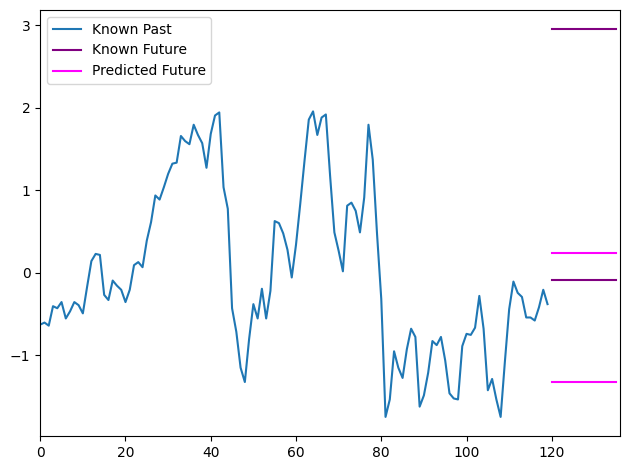

In [21]:
plot_a_prediction(M_test, y_test, y_predicted, index = 1000)

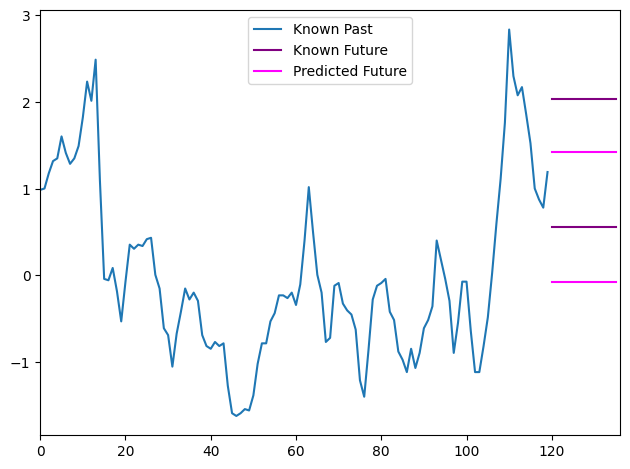

In [22]:
plot_a_prediction(M_test, y_test, y_predicted, index = 500)

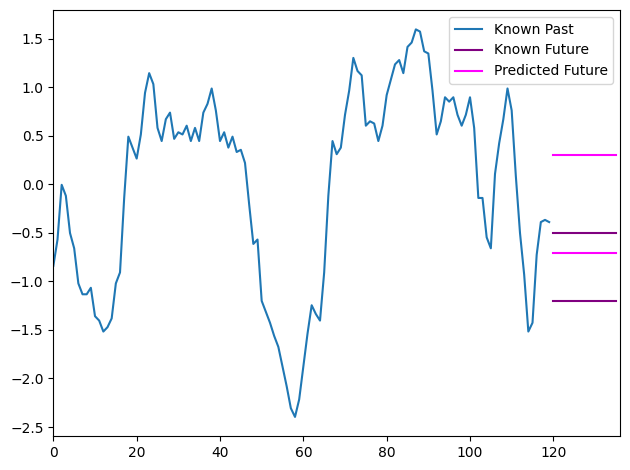

In [23]:
plot_a_prediction(M_test, y_test, y_predicted, index = 700)

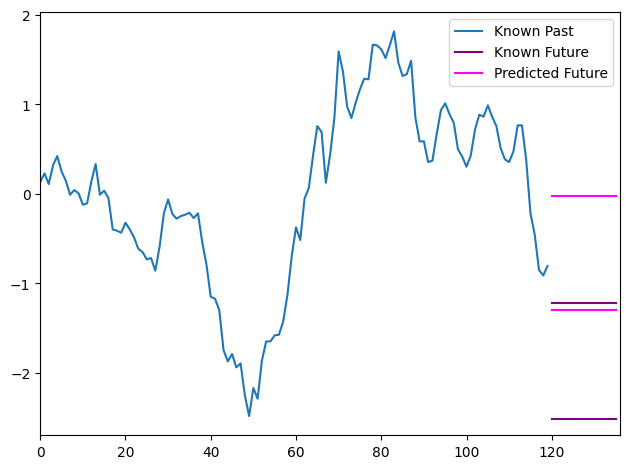

In [25]:
plot_a_prediction(M_test, y_test, y_predicted, index = 1200)